In [6]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [7]:
data = pd.read_csv('insurance.csv')

In [8]:
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [9]:
print("Total missing values:", data.isna().sum().sum())


Total missing values: 0


In [10]:
data['children'] = data['children'].astype(str)


In [11]:
print("Total non-numeric columns:", len(data.select_dtypes('object').columns))


Total non-numeric columns: 4


In [12]:
{column: list(data[column].unique()) for column in data.select_dtypes('object').columns}

{'sex': ['female', 'male'],
 'children': ['0', '1', '3', '2', '5', '4'],
 'smoker': ['yes', 'no'],
 'region': ['southwest', 'southeast', 'northwest', 'northeast']}

In [13]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [14]:
def preprocess_inputs(df, scaler, train_size=0.7):

    df = df.copy()

    # Binary encode sex and smoker columns
    df = binary_encode(df, 'sex', 'male')
    df = binary_encode(df, 'smoker', 'yes')

    # One-hot encode the children and region columns
    df = onehot_encode(df, 'children', 'ch')
    df = onehot_encode(df, 'region', 're')

    # Split df in X and y
    y = df['charges'].copy()
    X = df.drop('charges', axis=1).copy()

    # Scale X with the given scaler
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=123)

    return X_train, X_test, y_train, y_test

In [15]:
X_train, X_test, y_train, y_test = preprocess_inputs(data, StandardScaler(), train_size=0.7)


In [16]:
models = {
    '         OLS Model:': LinearRegression(),
    '          L2 Model:': Ridge(),
    '          L1 Model:': Lasso(),
}
for model in models.values():
    model.fit(X_train, y_train)

In [17]:
print("Model R^2 Scores:\n-----------------")

for name, model in models.items():
    print(name, model.score(X_test, y_test))

Model R^2 Scores:
-----------------
         OLS Model: 0.7593545908497942
          L2 Model: 0.7593579364036089
          L1 Model: 0.7593697076110314


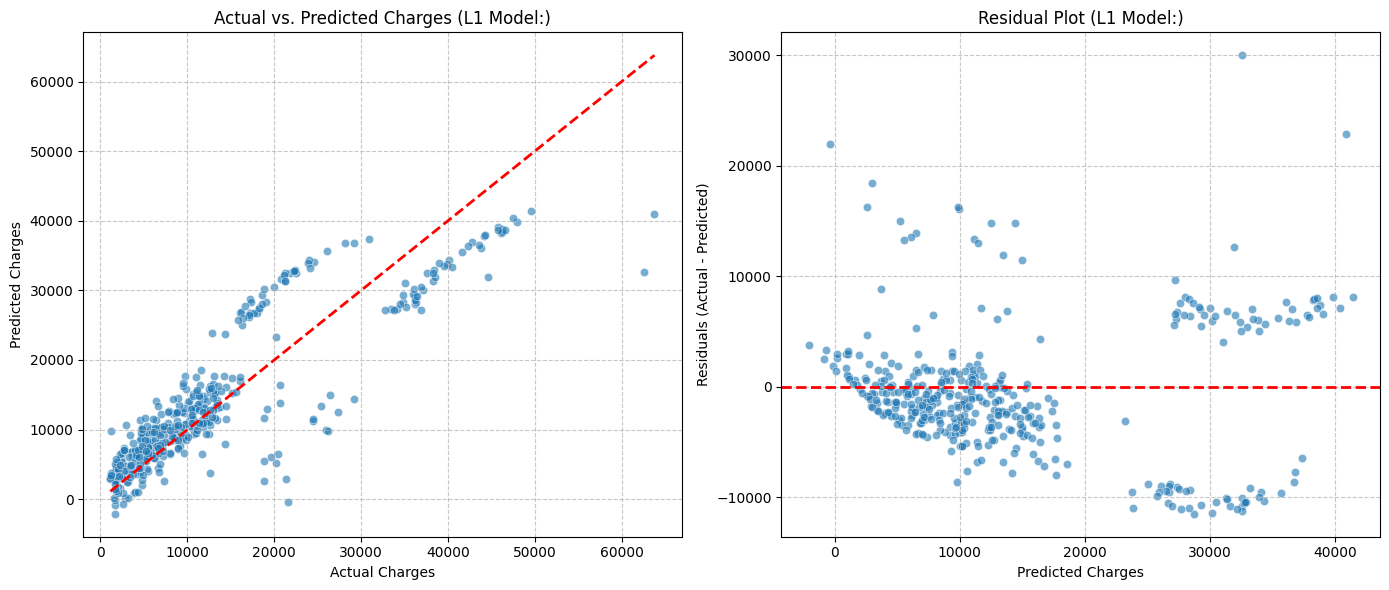

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Choose one model for visualization (e.g., L1 Model)
model_name = '          L1 Model:'
l1_model = models[model_name]

# Get predictions for the chosen model
y_pred_l1 = l1_model.predict(X_test)

# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Plot 1: Actual vs. Predicted Values
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
sns.scatterplot(x=y_test, y=y_pred_l1, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title(f'Actual vs. Predicted Charges ({model_name.strip()})')
plt.grid(True, linestyle='--', alpha=0.7)

# Plot 2: Residual Plot
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
residuals_l1 = y_test - y_pred_l1
sns.scatterplot(x=y_pred_l1, y=residuals_l1, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Charges')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title(f'Residual Plot ({model_name.strip()})')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

print("Model Evaluation Metrics:\n-----------------")

for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    print(f"{name.strip()}:\n  MAE: {mae:.2f}\n  MSE: {mse:.2f}\n  RMSE: {rmse:.2f}")


Model Evaluation Metrics:
-----------------
OLS Model::
  MAE: 4253.23
  MSE: 34378589.20
  RMSE: 5863.33
L2 Model::
  MAE: 4254.39
  MSE: 34378111.26
  RMSE: 5863.29
L1 Model::
  MAE: 4252.95
  MSE: 34376429.62
  RMSE: 5863.14


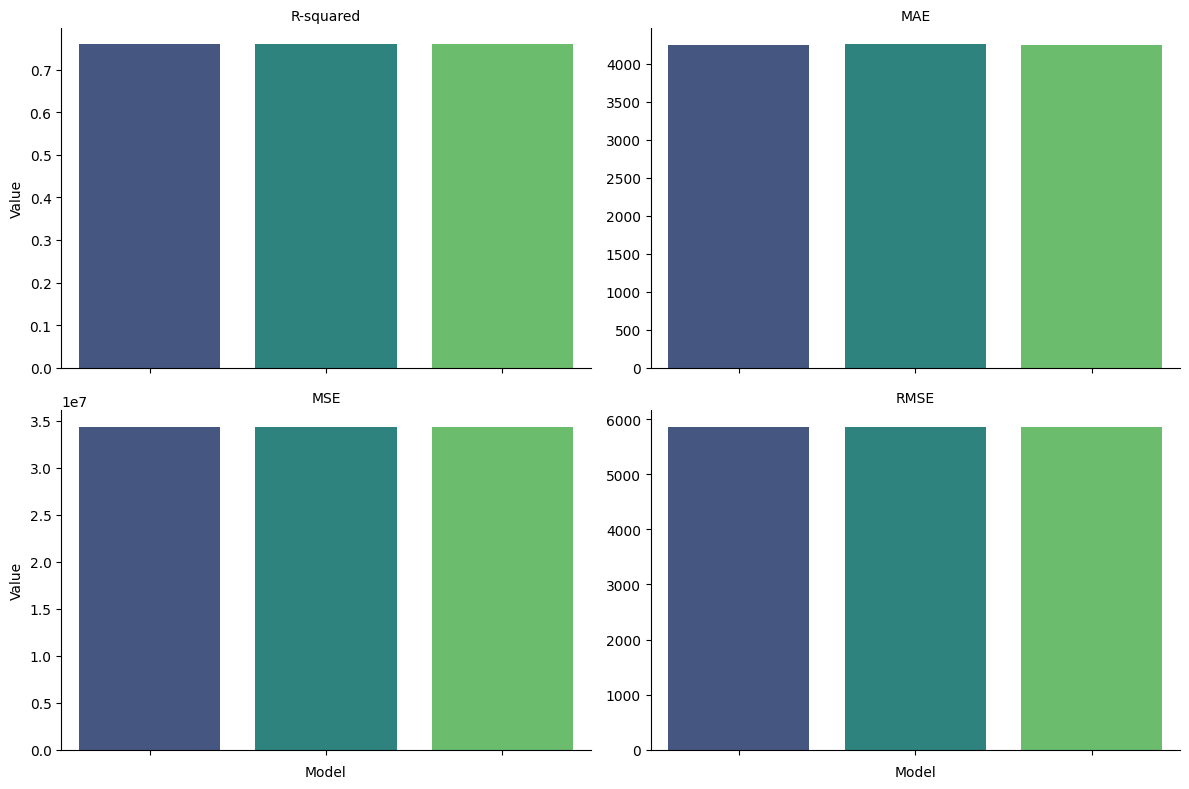

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Recalculate model performance metrics
model_performance = []

for name, model in models.items():
    y_pred = model.predict(X_test)
    r2 = model.score(X_test, y_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    model_performance.append({
        'Model': name.strip(),
        'R-squared': r2,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse
    })

performance_df = pd.DataFrame(model_performance)

# Melt the DataFrame to a long format for plotting multiple metrics
performance_melted = performance_df.melt(id_vars='Model', var_name='Metric', value_name='Value')


# Create a categorical plot
g = sns.catplot(data=performance_melted, x='Model', y='Value', col='Metric',
                kind='bar', col_wrap=2, height=4, aspect=1.5, palette='viridis',
                sharey=False, hue='Model', legend=False) # Added hue='Model' and legend=False

g.set_axis_labels("Model", "Value")
g.set_titles("{col_name}")
g.set_xticklabels(rotation=45, ha='right')
g.tight_layout()
plt.show()